<a href="https://colab.research.google.com/github/Sruthij93/BrainTumorClassification_model/blob/main/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 146M/149M [00:00<00:00, 198MB/s]
100% 149M/149M [00:00<00:00, 209MB/s]


In [3]:
def get_class_paths(path):
  classes = []
  class_paths = []

  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    # check if label path is a directory
    if os.path.isdir(label_path):
      # iterate through the images in the directory and form the path
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)
        # add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)

  # create a dataframe with classpath and labels
  df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
  return df


In [4]:
tr_df = get_class_paths('/content/Training')


In [5]:
tr_df

,Class Path,Class
0,/content/Training/notumor/Tr-no_0794.jpg,notumor
1,/content/Training/notumor/Tr-no_1039.jpg,notumor
2,/content/Training/notumor/Tr-no_0972.jpg,notumor
3,/content/Training/notumor/Tr-no_0559.jpg,notumor
4,/content/Training/notumor/Tr-no_1252.jpg,notumor
...,...,...
5707,/content/Training/glioma/Tr-gl_0255.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0182.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0553.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0380.jpg,glioma


In [6]:
ts_df = get_class_paths("/content/Testing")

In [7]:
ts_df

,Class Path,Class
0,/content/Testing/notumor/Te-no_0097.jpg,notumor
1,/content/Testing/notumor/Te-no_0301.jpg,notumor
2,/content/Testing/notumor/Te-noTr_0000.jpg,notumor
3,/content/Testing/notumor/Te-no_0222.jpg,notumor
4,/content/Testing/notumor/Te-no_0139.jpg,notumor
...,...,...
1306,/content/Testing/glioma/Te-gl_0280.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0163.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0194.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0146.jpg,glioma


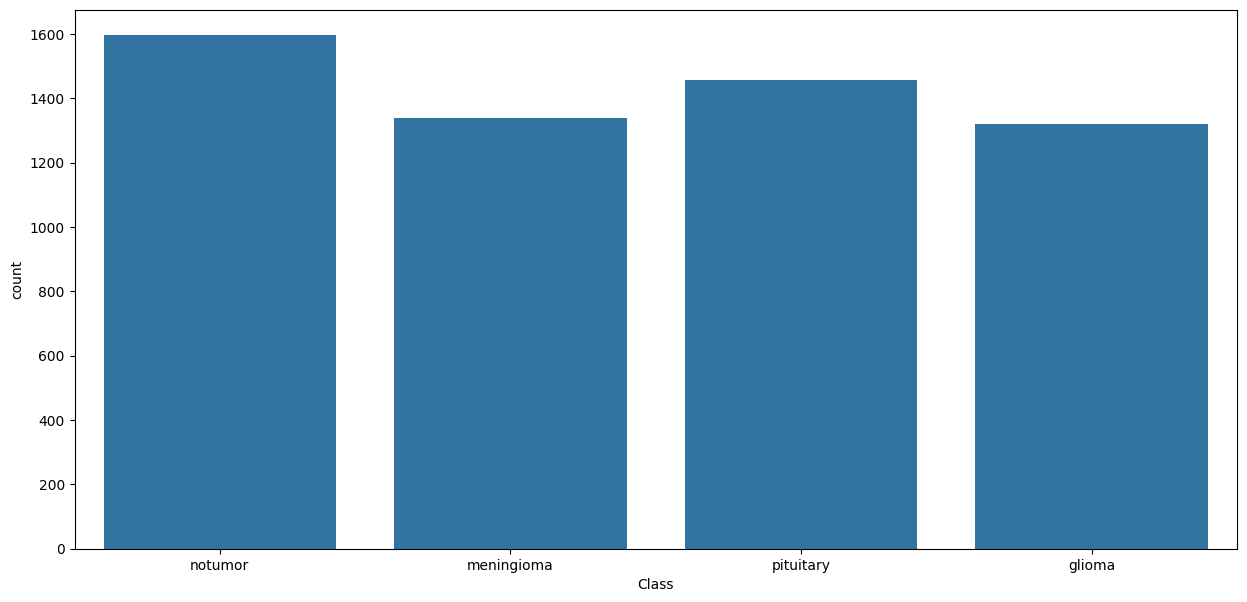

In [8]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df, x=tr_df['Class'])
plt.show()

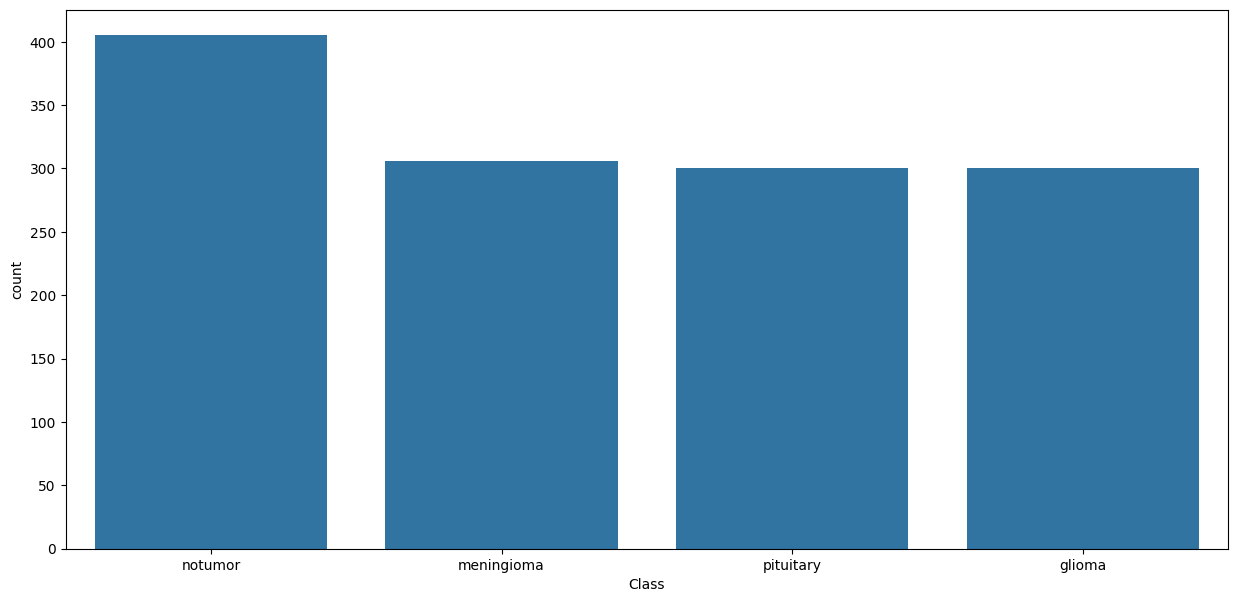

In [9]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df, x=ts_df['Class'])
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [11]:
# set aside part of test dataset to test and validation dataset
valid_df, ts_df = train_test_split(ts_df, train_size = 0.5, stratify = ts_df['Class'])

In [12]:
valid_df

,Class Path,Class
281,/content/Testing/notumor/Te-no_0322.jpg,notumor
266,/content/Testing/notumor/Te-no_0289.jpg,notumor
309,/content/Testing/notumor/Te-no_0350.jpg,notumor
796,/content/Testing/pituitary/Te-pi_0288.jpg,pituitary
247,/content/Testing/notumor/Te-no_0344.jpg,notumor
...,...,...
989,/content/Testing/pituitary/Te-pi_0266.jpg,pituitary
241,/content/Testing/notumor/Te-no_0244.jpg,notumor
896,/content/Testing/pituitary/Te-pi_0134.jpg,pituitary
69,/content/Testing/notumor/Te-no_0134.jpg,notumor


In [13]:
ts_df

,Class Path,Class
775,/content/Testing/pituitary/Te-pi_0102.jpg,pituitary
189,/content/Testing/notumor/Te-no_0352.jpg,notumor
582,/content/Testing/meningioma/Te-me_0212.jpg,meningioma
707,/content/Testing/meningioma/Te-me_0238.jpg,meningioma
81,/content/Testing/notumor/Te-no_0340.jpg,notumor
...,...,...
633,/content/Testing/meningioma/Te-me_0127.jpg,meningioma
1106,/content/Testing/glioma/Te-gl_0118.jpg,glioma
744,/content/Testing/pituitary/Te-pi_0042.jpg,pituitary
739,/content/Testing/pituitary/Te-pi_0206.jpg,pituitary


In [14]:
# Preprocess the data
batch_size = 32 # size of data to process at once. (16,32,64,128 - common values)

# resize the images to same size (same dims)
img_size = (299,299)

# easily preprocess the images by rescaling the pixel values and adjusting brightness (more robust and generalize to new data)
image_generator = ImageDataGenerator(rescale = 1/255, brightness_range = (0.8, 1.2))

# we do not change the brightness for the test data so data is consistent and does not randomly adjust the brightness.
ts_gen = ImageDataGenerator(rescale = 1/255)

In [15]:
# create 3 dataflows: take image data from dataframes and prep them to be fed into the datamodel
tr_gen = image_generator.flow_from_dataframe(tr_df, x_col = "Class Path", y_col = "Class", batch_size = batch_size, target_size = img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col = "Class Path", y_col = "Class", batch_size = batch_size, target_size = img_size)

ts_fen = ts_gen.flow_from_dataframe(ts_df, x_col = "Class Path", y_col = "Class", batch_size = 16, target_size = img_size, shuffle= False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


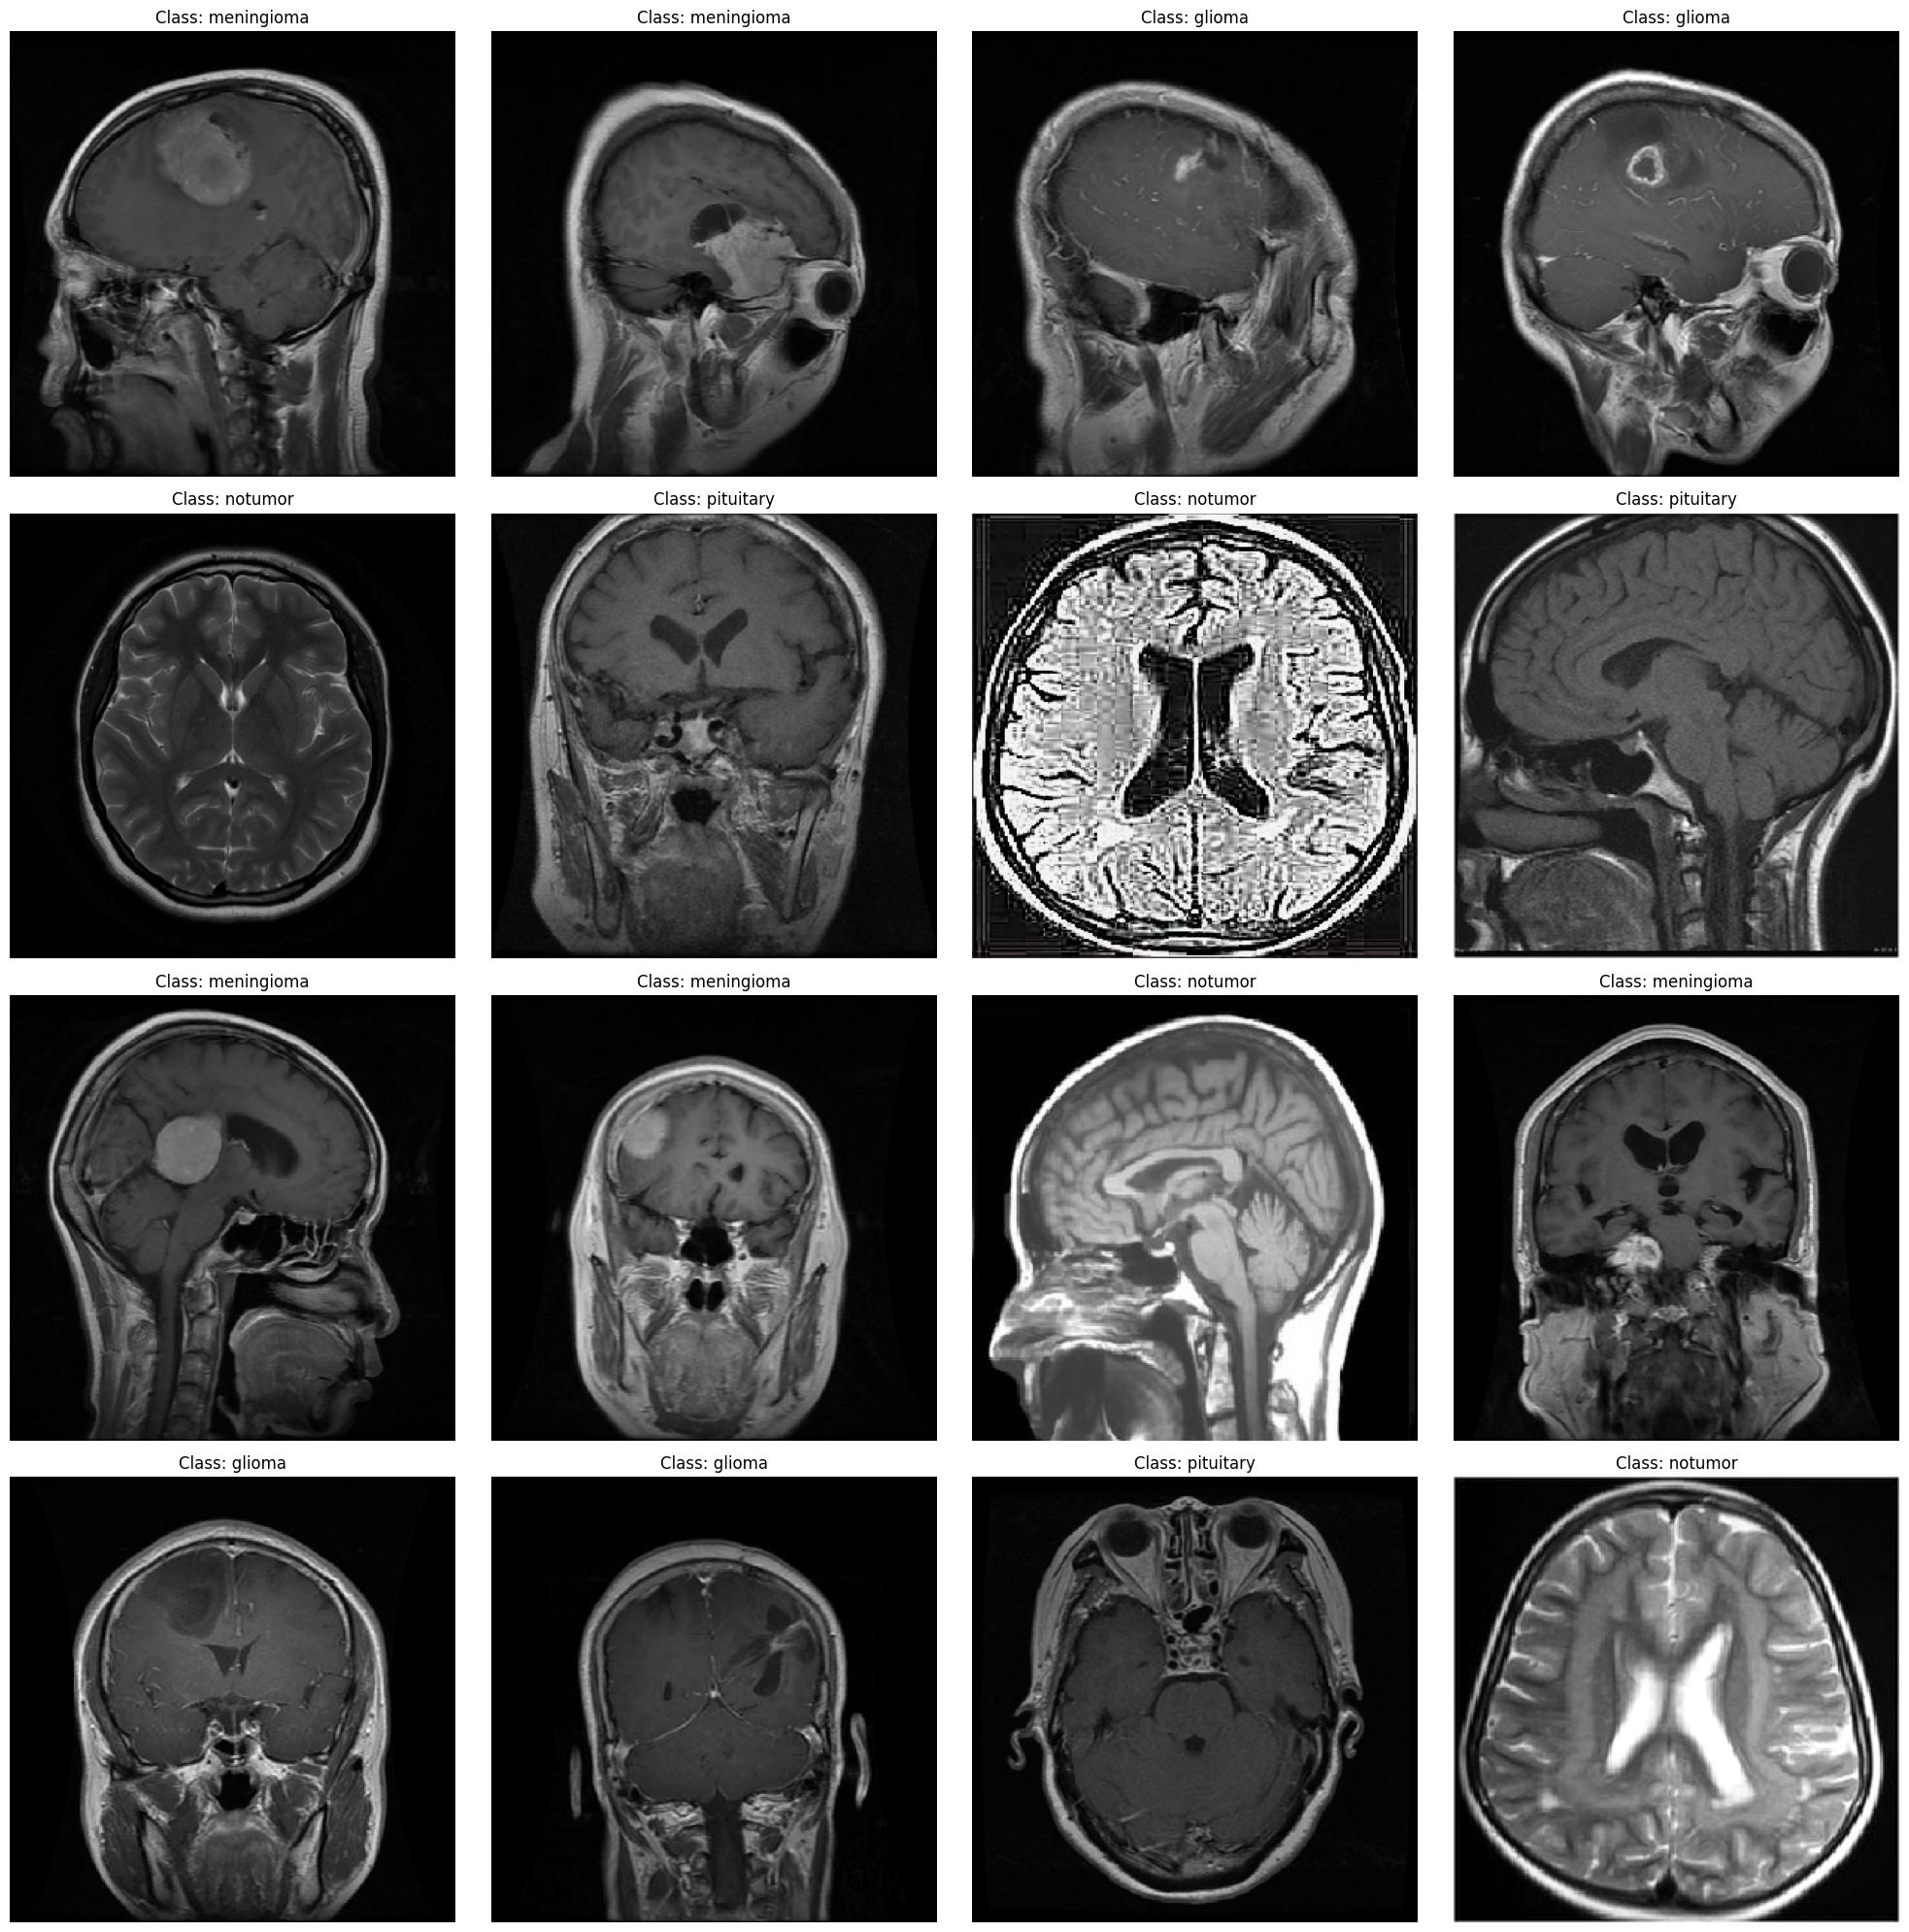

In [ ]:
plt.figure(figsize = (20, 20))
for i in range(16):
  plt.subplot(4,4,i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  # get the class index
  class_index = np.argmax(label)

  # get the list of class names and class indices
  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  # find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  # get the class name using the index position
  class_name = class_names[index_position]

  plt.title(f"Class: {class_name}")
  plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(include_top = False, weights = 'imagenet', input_shape=img_shape, pooling='max')

# pooling- max looks like at certain sections of the image. Where the feature is at its max standout pixel. Reduces the amount of info to process while still keeping the most important features.

# dropout is to avoid overfitting. randomly drop some of the neurons in the model to help generalize the model to data.
# relu learns the non-linear relationship between the input and output
# softmax takes output from prev layer and outputs the prob of the classes.
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate = 0.3),
    Dense(128, activation ='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
]
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# compile the model
# Adamax- smart asst for the model. Adjusts how big of steps it takes when updating the weights of the model.
# Categorical crossentropy- how much the predicted probabilities differ from the actual probability of each class in the dataset. Penalizes the model heavily for incorrect predictions.

model.compile(Adamax(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ['accuracy', Precision(), Recall()])

In [ ]:
# Train the ML model
hist = model.fit(tr_gen, epochs = 5, validation_data = valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.7571 - loss: 0.6883 - precision: 0.8326 - recall: 0.6516 - val_accuracy: 0.9557 - val_loss: 0.1520 - val_precision: 0.9584 - val_recall: 0.9496
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 159s 759ms/step - accuracy: 0.9774 - loss: 0.0741 - precision: 0.9780 - recall: 0.9768 - val_accuracy: 0.8977 - val_loss: 0.3329 - val_precision: 0.9002 - val_recall: 0.8947
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 145s 758ms/step - accuracy: 0.9915 - loss: 0.0353 - precision: 0.9917 - recall: 0.9913 - val_accuracy: 0.9679 - val_loss: 0.0949 - val_precision: 0.9724 - val_recall: 0.9664
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 135s 749ms/step - accuracy: 0.9965 - loss: 0.0143 - precision: 0.9965 - recall: 0.9965 - val_accuracy: 0.9924 - val_loss: 0.0276 - val_precision: 0.9924 - val_recall: 0.9924
Epoch 5/5
123/179 ━━━━━━━━━━━━━━━━━━━━ 40s 726ms/step - accuracy: 0.9956 - loss: 0.0111 - precision: 0.9957 - recall: 0.9956

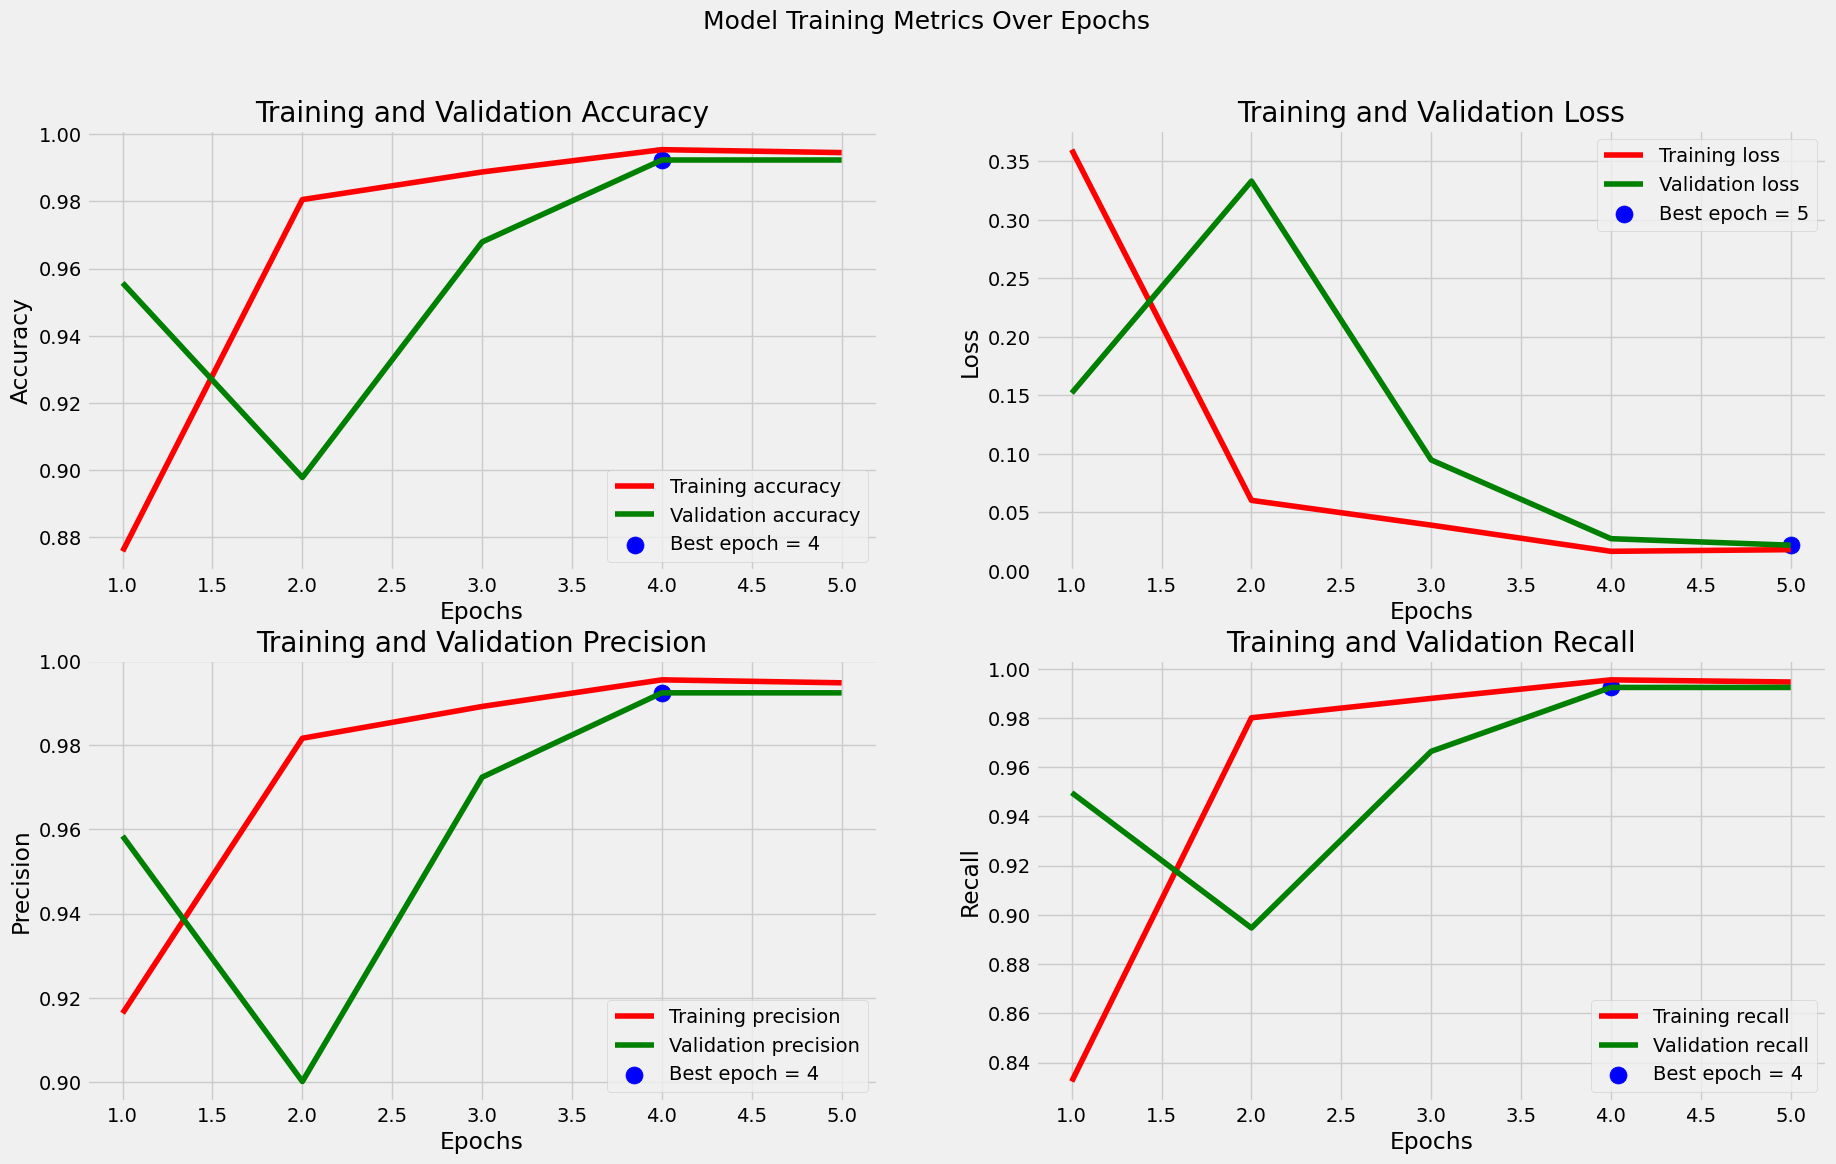

In [ ]:

# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx+1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize = (20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric]) +1)

  plt.plot(epochs, tr_metrics[metric], 'r', label = f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label = f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=18)
plt.show()

In [ ]:
# Evaluate the model performance
train_score = model.evaluate(tr_gen, verbose = 1)
valid_score = model.evaluate(valid_gen, verbose = 1)
test_score = model.evaluate(ts_fen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - accuracy: 0.9999 - loss: 0.0011 - precision: 0.9999 - recall: 0.9999
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9906 - loss: 0.0117 - precision: 0.9906 - recall: 0.9906
 1/41 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 5.1438e-05 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9914 - loss: 0.0223 - precision: 0.9914 - recall: 0.9914
Train Accuracy: 99.98%
Train Loss: 0.0014


Validation Accuracy: 99.24%
Validation Loss: 0.0200


Test Accuracy: 98.78%
Test Loss: 0.0314


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step


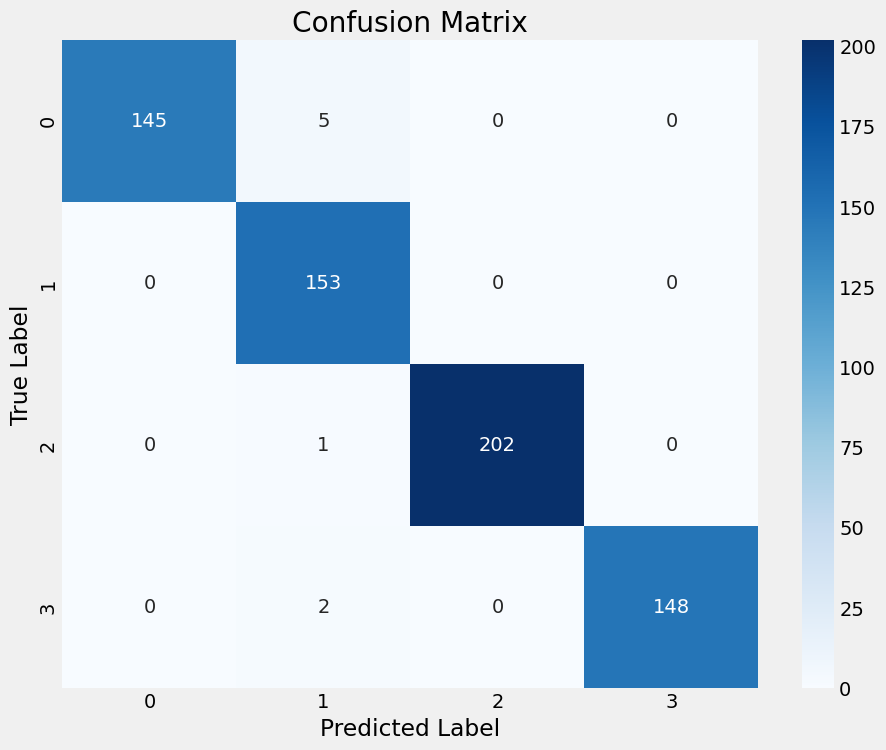

In [ ]:
# Confusion matrix- way to check where the model succeeeds and makes mistakes
preds = model.predict(ts_fen)
y_pred = np.argmax(preds, axis = 1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}

# create and display the confusion matrix
cm = confusion_matrix(ts_fen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, fmt = 'd', cmap='Blues', xticklabels = labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Visualize the predictions of the model on a few test images.
from PIL import Image

def predict(img_path: str) -> None:
  # Get the class labels
  labels = list(class_dict.keys())

  # create figure
  plt.figure(figsize=(6,8))

  # load and preprocess the image
  img = Image.open(img_path)
  resized_img = img.resize((299,299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array, axis = 0) /255.0

  # get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  # get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  # plot the original image
  plt.subplot(2,1,1)
  plt.imshow(resized_img)
  plt.title(f"Input MRI Image\nPredicted:{predicted_class}")

  # plot prediction probabilities
  plt.subplot(2,1,2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel("Probability", fontsize = 15)
  plt.title("Class Probabilities")

  # Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt = "%.2f")

  plt.tight_layout()
  plt.show()

  print(f"\nPredicted tumor types: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


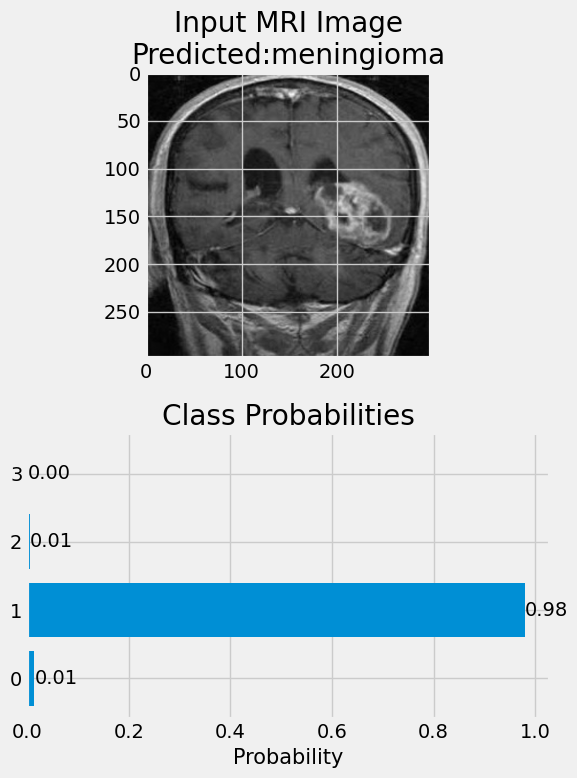


Predicted tumor types: meningioma


In [ ]:
predict("/content/Testing/meningioma/Te-meTr_0007.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


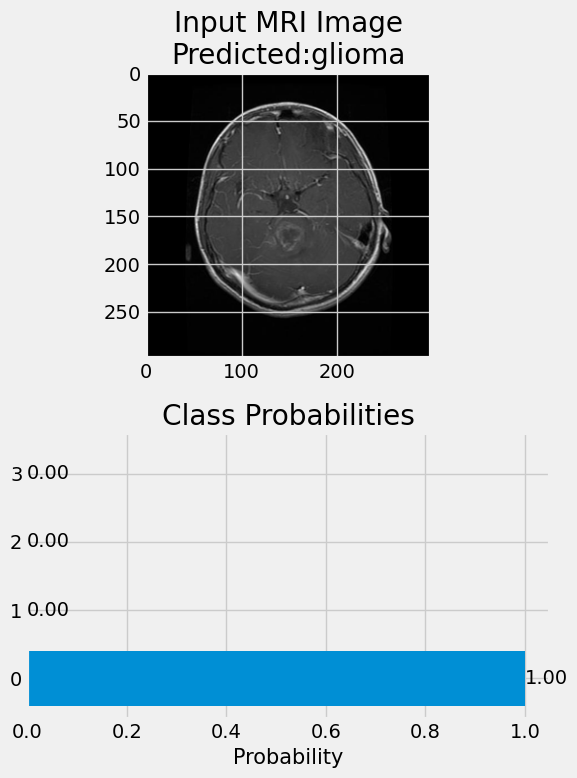


Predicted tumor types: glioma


In [ ]:
predict("/content/Testing/glioma/Te-glTr_0007.jpg")

In [ ]:
model.save_weights("xception_model.weights.h5")

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers

In [17]:
batch_size = 16 #reduce the training time, (new: increasing batch_size from 16 to 32)
img_size = (224, 224)

image_generator = ImageDataGenerator(rescale = 1/255, brightness_range = (0.8, 1.2), rotation_range=20, zoom_range=0.15)

ts_gen = ImageDataGenerator(rescale = 1/255)

tr_gen = image_generator.flow_from_dataframe(tr_df, x_col = "Class Path", y_col = "Class", batch_size = batch_size, target_size = img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col = "Class Path", y_col = "Class", batch_size = batch_size, target_size = img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col = "Class Path", y_col = "Class", batch_size = 16, target_size = img_size, shuffle = False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [18]:
# create a sequential model
cnn_model = Sequential()

# Convolutional layers
# 4 convolutional blocks with each block having different number of convolutional filters
# filters: each of them identify diff visual elements in an image like edges, textures or shapes
# filters: extracts features
cnn_model.add(Conv2D(512, (3,3), padding='same', input_shape = (224,224,3), activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2))) #reduces dimensions of the image by taking just the prominent features of the image

cnn_model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25)) #randomly turns off some connections to reduce overfitting

cnn_model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) #64 filters to find the highest level of features
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))
cnn_model.add(Dense(4, activation='softmax')) # output later with 4 neurons for the 4 classes

# Compile the model
cnn_model.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# display model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 512)       │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,779,460 (18.23 MB)

 Trainable params: 4,777,540 (18.22 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [21]:
history = cnn_model.fit(tr_gen, epochs = 10, validation_data= valid_gen)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 153s 425ms/step - accuracy: 0.9690 - loss: 0.2592 - precision: 0.9705 - recall: 0.9686 - val_accuracy: 0.9557 - val_loss: 0.2903 - val_precision: 0.9568 - val_recall: 0.9466
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 201s 422ms/step - accuracy: 0.9676 - loss: 0.2625 - precision: 0.9693 - recall: 0.9649 - val_accuracy: 0.9618 - val_loss: 0.2636 - val_precision: 0.9618 - val_recall: 0.9618
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 210s 445ms/step - accuracy: 0.9799 - loss: 0.2329 - precision: 0.9807 - recall: 0.9790 - val_accuracy: 0.9588 - val_loss: 0.2830 - val_precision: 0.9601 - val_recall: 0.9557
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 153s 423ms/step - accuracy: 0.9791 - loss: 0.2211 - precision: 0.9795 - recall: 0.9777 - val_accuracy: 0.8244 - val_loss: 0.8515 - val_precision: 0.8339 - val_recall: 0.8198
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 152s 421ms/step - accuracy: 0.9744 - loss: 0.2166 - precision: 0.9762 - recall: 0.9731 - val_accuracy: 0

In [22]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

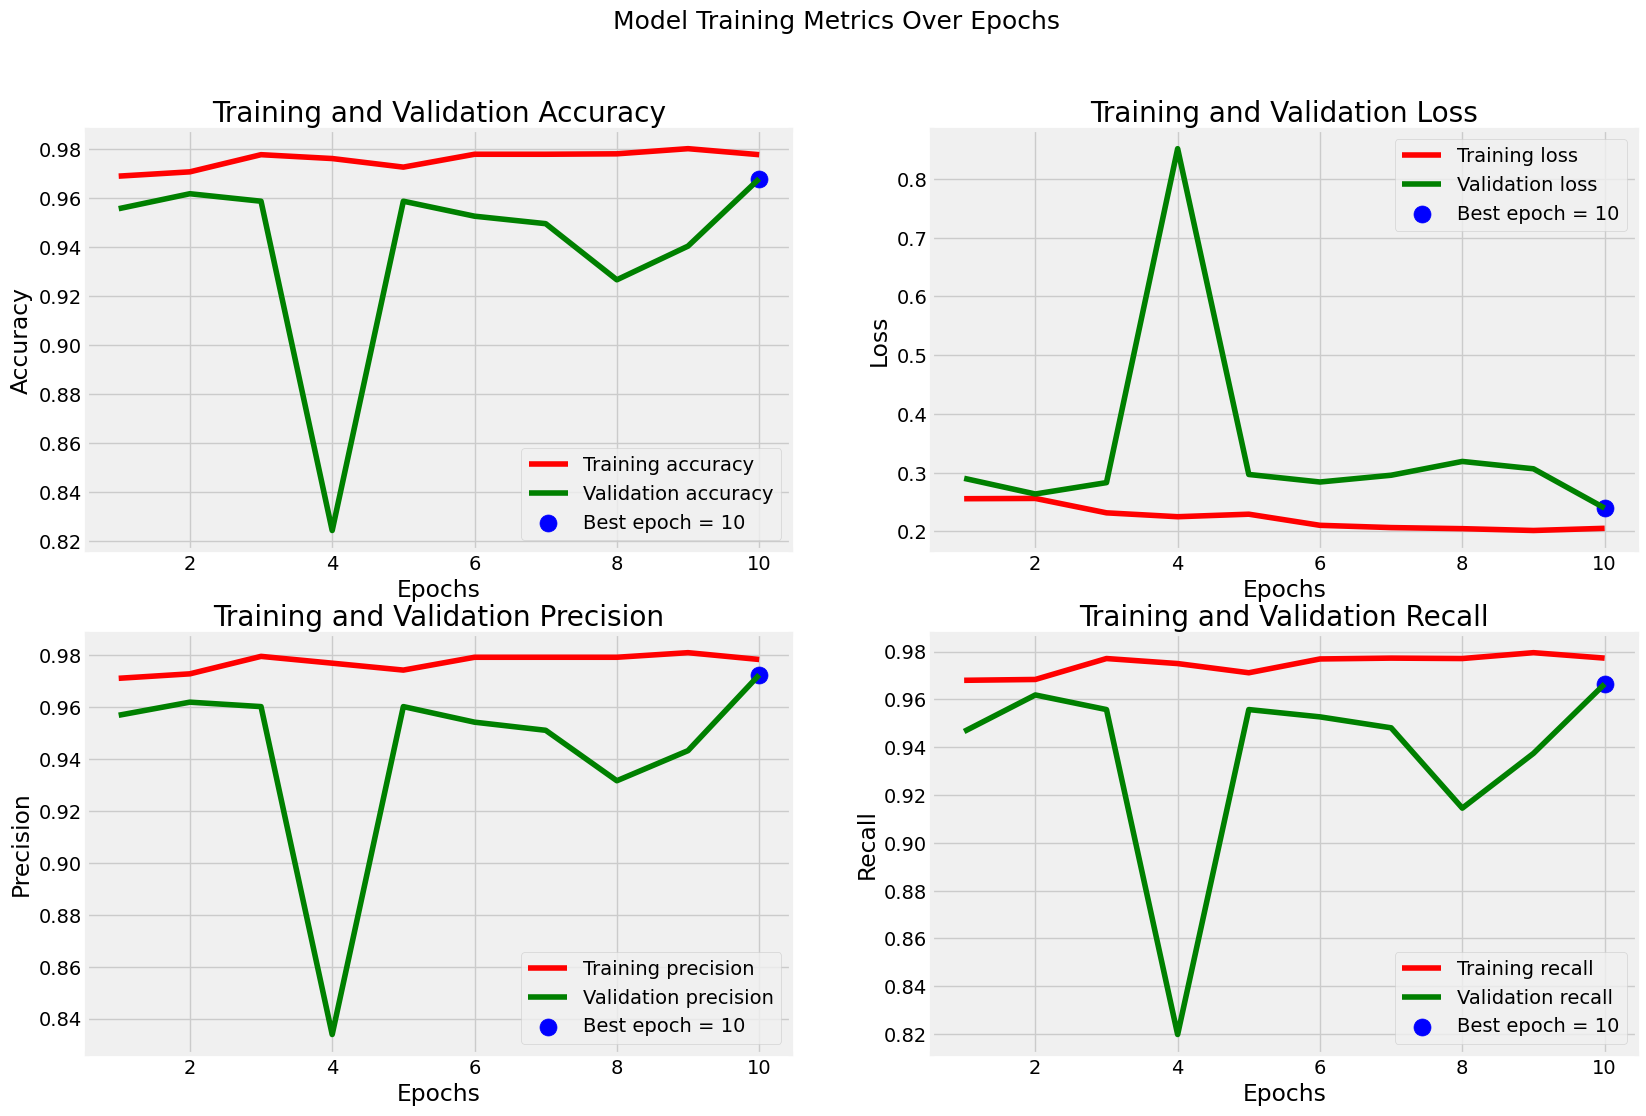

In [24]:
# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx+1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize = (20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric]) +1)

  plt.plot(epochs, tr_metrics[metric], 'r', label = f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label = f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=18)
plt.show()

In [25]:
# Evaluate the cnn model performance
train_score = cnn_model.evaluate(tr_gen, verbose = 1)
valid_score = cnn_model.evaluate(valid_gen, verbose = 1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 110s 307ms/step - accuracy: 0.9848 - loss: 0.1861 - precision: 0.9856 - recall: 0.9844
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.9747 - loss: 0.2120 - precision: 0.9747 - recall: 0.9745
 1/41 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 0.1437 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9738 - loss: 0.2044 - precision: 0.9770 - recall: 0.9738
Train Accuracy: 98.74%
Train Loss: 0.1825


Validation Accuracy: 96.18%
Validation Loss: 0.2363


Test Accuracy: 97.41%
Test Loss: 0.2003


In [1]:
# Confusion matrix- way to check where the model succeeeds and makes mistakes
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis = 1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}

# create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, fmt = 'd', cmap='Blues', xticklabels = labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'cnn_model' is not defined

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       150
           1       0.89      0.99      0.93       153
           2       1.00      1.00      1.00       203
           3       0.99      0.99      0.99       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [ ]:
cnn_model.save("cnn_model.h5")

## Challenges: Transfer Learning with a different Base Model

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
input_shape = (299, 299, 3)

resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

resnet_model = Sequential([
    resnet_base_model,
    Flatten(),
    Dropout(rate = 0.3),
    Dense(128, activation ='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
]
)


# Part 2: Streamlit

In [2]:
! pip install streamlit pyngrok python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00


In [3]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata
import os

In [4]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)

In [5]:
def run_streamlit():
  os.system("streamlit run /content/app.py --server.port 8501")

In [13]:
%%writefile app.py
# saves our python file in colab as app.py

import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
import os
import google.generativeai as genai
from google.colab import userdata
import PIL.Image
from openai import OpenAI

from dotenv import load_dotenv
load_dotenv()

client = OpenAI(
  base_url="https://api.groq.com/openai/v1",
  api_key=os.environ.get("GROQ_API_KEY")
)

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

output_dir = 'saliency_maps'
os.makedirs(output_dir, exist_ok=True)

def generate_explanation(img_path, model_prediction, confidence, selected_llm):

  prompt= f"""You are an expert neurologist. You are tasked with explaining a saliency map of a brain tumor MRI scan.
  The saliency map was generated by a deep learning model that was trained to classify brain tumors as either glioma,
  meningioma, pituitary or no tumor.

  Patients do not know that a model is predicting this. so dont tell them that the model is predicting.

  The scan highlights the regions of the image that the machine learning model is focusing on to make the prediction,

  The deep learning model predicted the image to be of class '{model_prediction}' with a confidence of {confidence * 100}%.

  In your response:
  - Explain what regions of the brain the model is focusing on, based on the saliency map. Refer to the regions highlighted in light cyan, those are the regions where the model is focusing on.
  - Explain possible reasons why the model made the prediction it did.
  - keep your explanation to 4 sentences max.
  - NEVER EVER mention anything like 'The saliency map hightlights the regions the model is focusing on, which are in light cyan' in your explanation. DONT TALK ABOUT THE MODEL OR MAP.

  Let's think step by step about this. Verify step by step.
  """

  img = PIL.Image.open(img_path)

  # model = genai.GenerativeModel(model_name='gemini-1.5-flash')

  if selected_llm == 'gemini-1.5-flash':
      model = genai.GenerativeModel(model_name='gemini-1.5-flash')
      response = model.generate_content([prompt, img])

      return response.text

  elif selected_llm == 'llama-3.1-70b-versatile' or selected_llm == 'gemma2-9b-it':
      response = client.chat.completions.create(
      model = selected_llm,
      messages = [{
        'role':'user',
        'content': prompt
      }]
      )
      return response.choices[0].message.content

def generate_comp_report(img_path, model_prediction, explanation, confidence, selected_llm):

  prompt= f'''Generate a detailed and comprehensive report based on the provided MRI scan and the patient's tumor diagnosis.
    The scan highlights the regions of the image that the machine learning model is focusing on to make the prediction.

    The deep learning model predicted the image to be of class '{model_prediction}' with a confidence of {confidence * 100}%.

    The report should be structured as follows:

          Model Predictions:
          - Summarize the key findings from the analysis of the MRI scan.
          - Highlight areas of concern, abnormalities, or regions requiring further examination.
          - Include probabilities or confidence levels of the predictions, if available.

          Additional Insights:
          - Provide an in-depth explanation of the findings, including possible implications of the observed patterns.
          - Relate the findings to potential diagnoses, physiological processes, or known medical conditions.
          - Explain how the scan results compare to typical or healthy cases.

          Historical Cases and References:
          - Draw parallels to similar cases in medical history or literature.
          - Mention any relevant statistics, research studies, or established medical guidelines that support the insights.

          Next Steps:
          - Recommend a clear course of action for the patient, such as further diagnostic tests, lifestyle changes, or immediate treatments.
          - Suggest considerations or follow-ups for the medical team, including consultations with specialists or additional imaging techniques.
          - Provide patient-friendly explanations for communication between doctors and the patient.

          Formatting Guidelines:

          - Use clear, professional, and medically accurate language.
          - Divide the report into sections with headings and bullet points for readability.
          - Ensure recommendations are actionable and evidence-based.
          - If any limitations of the predictions exist, highlight them to ensure transparency.

          We do not have patient's details so do not mention anything about it in the report.
      '''
  img = PIL.Image.open(img_path)



  if selected_llm == 'gemini-1.5-flash':
      model = genai.GenerativeModel(model_name='gemini-1.5-flash')
      response = model.generate_content([prompt, img])

      return response.text

  elif selected_llm == 'llama-3.1-70b-versatile' or selected_llm == 'gemma2-9b-it':
      response = client.chat.completions.create(
      model = selected_llm,
      messages = [{
        'role':'user',
        'content': prompt
      }]
      )
      return response.choices[0].message.content



def load_xception_model(model_path):
  img_shape = (299,299,3)
  base_model = tf.keras.applications.Xception(include_top = False, weights = 'imagenet', input_shape = img_shape, pooling = 'max')

  model = Sequential([
      base_model,
      Flatten(),
      Dropout(rate=0.3),
      Dense(128, activation='relu'),
      Dropout(rate=0.25),
      Dense(4, activation='softmax')
  ])

  model.build((None,) + img_shape) #get the model to accept the input img_size

  # compile the model
  model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

  model.load_weights(model_path)

  return model

# Saliency Map function
def generate_saliency_map(model, img_array, class_index, img_size):
  with tf.GradientTape() as tape:
    img_tensor = tf.convert_to_tensor(img_array)
    tape.watch(img_tensor)
    predictions = model(img_tensor)
    target_class = predictions[:, class_index]


  gradients = tape.gradient(target_class, img_tensor)
  gradients = tf.math.abs(gradients)
  gradients = tf.reduce_max(gradients, axis = -1)
  gradients = gradients.numpy().squeeze()

  # resize gradients to match original image size
  gradients = cv2.resize(gradients, img_size)

  # create a circular mask ffor the brain area
  center = (gradients.shape[0] // 2, gradients.shape[1] //2)
  radius = min(center[0], center[1]) -10
  y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
  mask = (x - center[0]) ** 2 + (y-center[1]) **2 <= radius **2

  # Apply mask to gradients
  gradients = gradients * mask

  # Normalize only the brain area
  brain_gradients = gradients[mask]
  if brain_gradients.max() > brain_gradients.min():
    brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
  gradients[mask] = brain_gradients

  # Apply a higher threshold
  threshold = np.percentile(gradients[mask], 80)
  gradients[gradients <threshold] = 0

  # Apply more aggressive smoothing
  gradients = cv2.GaussianBlur(gradients, (11,11), 0)

  # create a heatmap overlay with enhanced contrast
  heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

  # resize heatmap to match original image size
  heatmap = cv2.resize(heatmap, img_size)

  # Superimpose the heatmap on the original image with increased opacity
  original_img = image.img_to_array(img)
  superimposed_img = heatmap * 0.7 + original_img * 0.3
  superimposed_img = superimposed_img.astype(np.uint8)

  img_path = os.path.join(output_dir, uploaded_file.name)
  with open(img_path, 'wb') as file:
    file.write(uploaded_file.getbuffer())

  saliency_map_path =   f'saliency_maps/{uploaded_file.name}'

  # save the saliency map
  cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

  return superimposed_img


st.title("Brain Tumor Classification")

st.write("Upload an image of a brain MRI scan to classify.")

uploaded_file = st.file_uploader("Choose an image...", type=['jpg','jpeg','png'])

if uploaded_file is not None:

  # give options to user to select which model
  selected_model = st.radio(
      "Selected Model",
      ("Transfer Learning - Xception", "Custom CNN")
  )

  # give options to select the LLM model
  selected_llm = st.selectbox("Select LLM model for explanation", ('gemini-1.5-flash', 'llama-3.1-70b-versatile', 'gemma2-9b-it'))

  # load the selected model
  if selected_model == "Transfer Learning - Xception":
    model = load_xception_model('/content/drive/MyDrive/xception_model.weights.h5')
    img_size = (299, 299)
  else:
    model = load_model('/content/drive/MyDrive/cnn_model.h5')
    img_size = (224, 224)

  # Display the prediction button immediately
  predict_button = st.button("Predict Outcome")

  # Prediction button
  if predict_button:
    labels = ['Glioma', 'Meningioma', 'No tumor', 'Pituitary']
    img = image.load_img(uploaded_file, target_size = img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis = 0)
    img_array /= 255.0 #normalize the pixels to be between 0-1 as the model was trained

    prediction = model.predict(img_array)


    # Get the class with highest probability
    class_index = np.argmax(prediction[0])
    result = labels[class_index]

    # st.write(f"Predicted Class: {result}")

    # Display the result
    st.write("## Classification Results")
    # Create a visually distinct section
    result_container = st.container()
    # Create a visually distinct section with black background
    result_container = st.container()
    result_container.markdown(
         f"""
        <div style="background-color: #000000; color: #ffffff; padding: 30px; border-radius: 15px;">
            <div style="display: flex; justify-content: space-between; align-items: center;">
                <div style="flex: 1; text-align: center;">
                    <h3 style="color: #ffffff; margin-bottom: 10px; font-size: 20px;">Prediction</h3>
                    <p style="font-size: 36px; font-weight: 800; color: #FF0000; margin: 0;">
                        {result}
                    </p>
                </div>
                <div style="width: 2px; height: 80px; background-color: #ffffff; margin: 0 20px;"></div>
                <div style="flex: 1; text-align: center;">
                    <h3 style="color: #ffffff; margin-bottom: 10px; font-size: 20px;">Confidence</h3>
                    <p style="font-size: 36px; font-weight: 800; color: #2196F3; margin: 0;">
                        {prediction[0][class_index]:.4%}
                    </p>
                </div>
            </div>
        </div>
        """,
        unsafe_allow_html=True
    )

    colors = ['red' if i == class_index else 'blue' for i in range(len(labels))]
    # st.write("Predictions:")
    # for label, prob in zip(labels, prediction[0]):
    #   st.write(f"{label}: {prob:.4f}")

    # Create a horizontal bar chart for probabilities
    fig = go.Figure(go.Bar(
        x=prediction[0],
        y=labels,
        orientation='h', # Horizontal bars
        text=[f'{p:.2%}' for p in prediction[0]],
        marker=dict(color=colors) # Set bar color to cyan
    ))

    # Customize the layout for better readability
    fig.update_layout(
        title="Class Probabilities",
        xaxis_title="Probability",
        yaxis_title="Classes",
        xaxis=dict(range=[0, 1])  # Set x-axis range for probability [0-1]

    )

    # Display the chart in Streamlit
    st.plotly_chart(fig)

    saliency_map = generate_saliency_map(model, img_array, class_index, img_size)

    col1, col2 = st.columns(2)
    with col1:
      st.image(uploaded_file, caption='Uploaded Image', use_container_width = True)
    with col2:
      st.image(saliency_map, caption='Saliency Map', use_container_width = True)


    saliency_map_path = f'saliency_maps/{uploaded_file.name}'
    explanation = generate_explanation(saliency_map_path, result, prediction[0][class_index], selected_llm)
    st.write("## Explanation:")
    st.write(explanation)


    report = generate_comp_report(saliency_map_path, result, explanation, prediction[0][class_index], selected_llm)
    st.write("## Comprehensive Report:")
    st.write(report)







Overwriting app.py


In [14]:
# allow streamlit ot run concurrently with other tasks
thread = Thread(target=run_streamlit)
thread.start()

In [15]:
public_url = ngrok.connect(addr = '8501', proto="http", bind_tls = True)
print("Public URL: ", public_url)

Public URL:  NgrokTunnel: "https://6a23-34-74-231-33.ngrok-free.app" -> "http://localhost:8501"


In [30]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)

Closing tunnel: https://a55d-34-19-69-26.ngrok-free.app -> http://localhost:8501
Closing tunnel: https://50a8-34-19-69-26.ngrok-free.app -> http://localhost:8501
Closing tunnel: https://90da-34-19-69-26.ngrok-free.app -> http://localhost:8501
